# read data

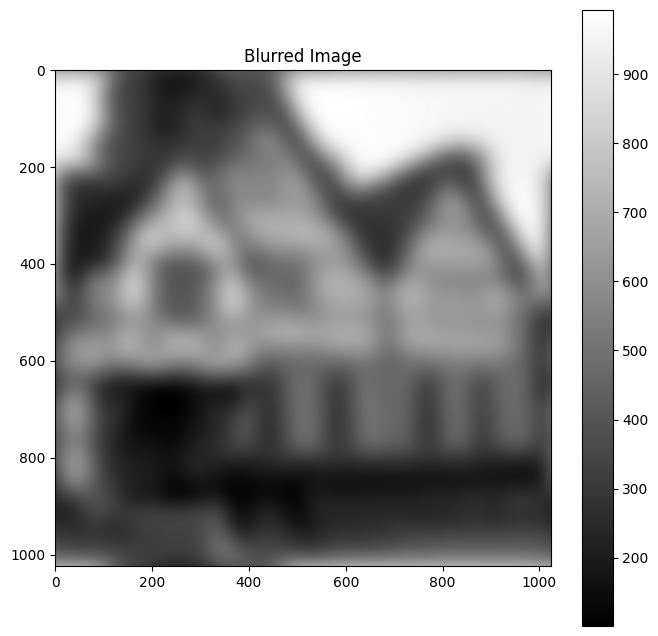

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Read the blurred image data
data = np.loadtxt("../cpresources/blur.txt")

# Assume it's a square image (which it is)
image = data 

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title('Blurred Image')
plt.colorbar()
plt.show()

# Part (b): Create the Gaussian point spread function

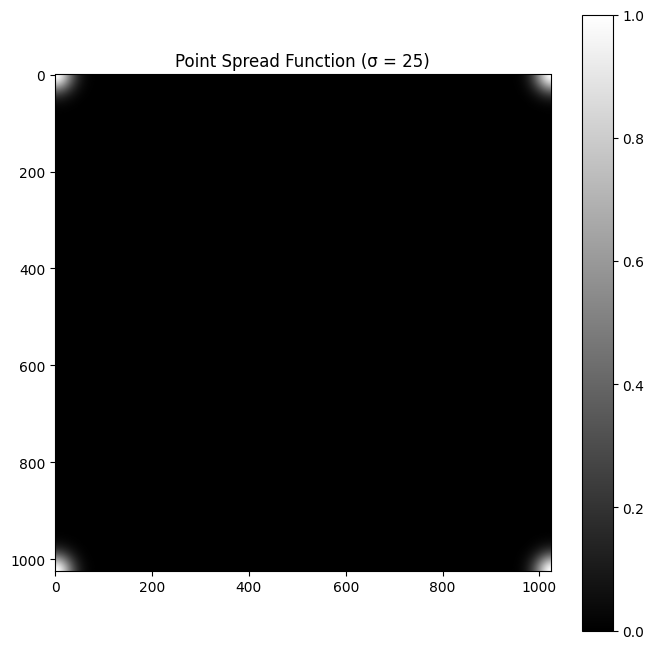

In [10]:
sigma = 25

size = image.shape[0]

# Create coordinate arrays for the point spread function
# Since it's periodic, we need coordinates from -size/2 to size/2
x = np.arange(size) - size // 2
y = np.arange(size) - size // 2
X, Y = np.meshgrid(x, y)

# Create the Gaussian point spread function
psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))

# Because of periodicity, we need to shift so that the center is at (0,0)
# which means bright spots appear in the corners
psf = np.fft.fftshift(psf)

# Display the point spread function
plt.figure(figsize=(8, 8))
plt.imshow(psf, cmap='gray')
plt.title('Point Spread Function (σ = 25)')
plt.colorbar()
plt.show()

# Part (c): Image deconvolution

Performing image deconvolution...
3. Computing Fourier transforms...
4. Performing deconvolution...
   - Protected 523252 coefficients from division by small values
   - Processed 2060 coefficients normally
5. Computing inverse Fourier transform...
6. Displaying results...


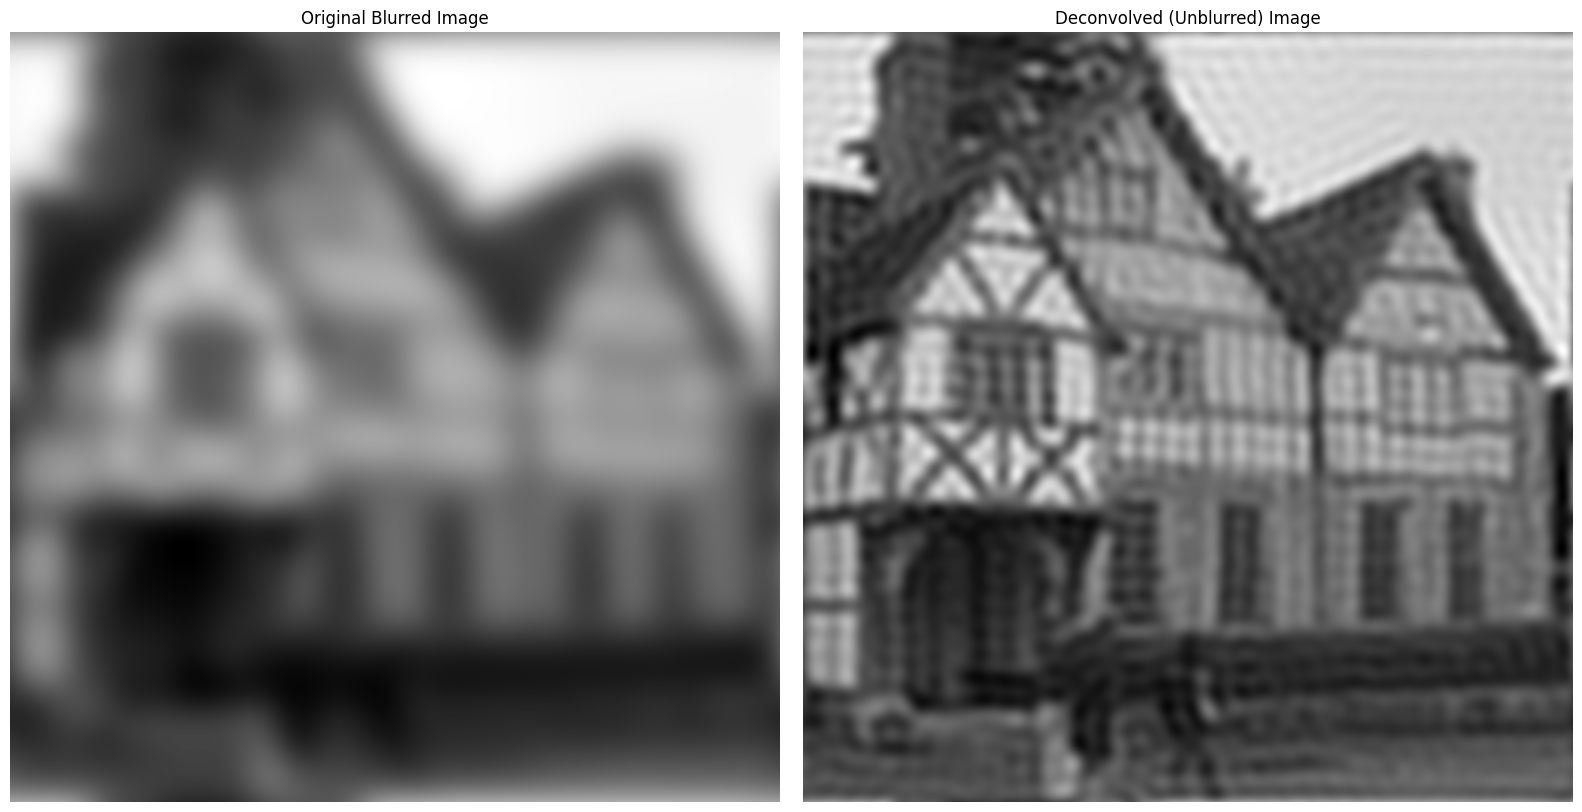

Deconvolution complete!


In [12]:
from numpy.fft import rfft2, irfft2

print("Performing image deconvolution...")

# iii) Fourier transform both
print("3. Computing Fourier transforms...")
blurred_fft = rfft2(image)
psf_fft = rfft2(psf)

# iv) Divide one by the other (with careful handling of small/zero values)
print("4. Performing deconvolution...")

# Set threshold epsilon as suggested in hint
epsilon = 1e-3

# Create a copy of the blurred FFT for the result
deconvolved_fft = blurred_fft.copy()

# Only divide where PSF FFT is large enough
# Where PSF FFT is too small, leave the blurred FFT coefficient unchanged
mask = np.abs(psf_fft) > epsilon
deconvolved_fft[mask] = blurred_fft[mask] / psf_fft[mask]

print(f"   - Protected {np.sum(~mask)} coefficients from division by small values")
print(f"   - Processed {np.sum(mask)} coefficients normally")

# v) Perform inverse transform to get the unblurred photo
print("5. Computing inverse Fourier transform...")
unblurred_image = irfft2(deconvolved_fft)

# vi) Display the unblurred photo
print("6. Displaying results...")

# Display both images side by side for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(image, cmap='gray')
ax1.set_title('Original Blurred Image')
ax1.axis('off')

ax2.imshow(unblurred_image, cmap='gray')
ax2.set_title('Deconvolved (Unblurred) Image')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("Deconvolution complete!")

# Theoretical Limitations of Image Deconvolution

## Fundamental Limitations

### 1. **Information Loss**
- Gaussian PSF with σ=25 attenuates high frequencies exponentially
- Frequencies beyond ~1/(2πσ) ≈ 0.0064 cycles/pixel are severely degraded
- At ε=10⁻³, we lose significant frequency components permanently

### 2. **Noise Amplification**
- Division by small PSF values amplifies noise by factor of 1/ε
- At ε=10⁻³: noise can be amplified up to 1000×
- Sets practical lower bound on usable epsilon

### 3. **Epsilon Selection Trade-offs**

| Epsilon | Effect | Consequence |
|---------|--------|-------------|
| Too small (10⁻⁶) | Divide by tiny values | Excessive noise amplification |
| Too large (10⁻¹) | Skip many coefficients | Loss of recoverable detail |
| Optimal (10⁻³-10⁻⁴) | Balanced approach | Good compromise |

### 4. **Theoretical Bounds**

**Information-theoretic limit**: Cannot recover frequencies where PSF_FFT = 0

**Practical limit**: Cannot reliably recover frequencies where PSF_FFT ≈ noise level

**Optimal ε formula**: `ε ≈ max(noise_level, PSF_max × 10⁻⁶)`

## Why Perfect Deconvolution is Impossible

1. **High frequencies are permanently lost** in the blurring process
2. **Noise contamination** at low PSF amplitudes  
3. **Finite precision** arithmetic limitations
4. **Model mismatch** (real PSF ≠ perfect Gaussian)

## Mathematical Analysis

### Frequency Domain Behavior
The Gaussian PSF in frequency domain is:
```
|PSF_FFT(f)| = exp(-2π²σ²f²)
```

### Critical Frequency
Beyond the critical frequency f_c ≈ 1/(2πσ), the PSF response drops exponentially:
- For σ = 25: f_c ≈ 0.0064 cycles/pixel
- PSF response at 2×f_c is only ~2% of peak value

### Noise Amplification Factor
When dividing by PSF_FFT values near ε:
```
Amplification = 1/ε = 1000× for ε = 10⁻³
```

### Signal-to-Noise Ratio Impact
The effective SNR after deconvolution becomes:
```
SNR_effective = SNR_original × min(|PSF_FFT|, ε) / ε
```

## Practical Implications

- **Deconvolution is fundamentally limited** by information loss during blurring
- **Epsilon parameter** represents unavoidable trade-off between detail and noise
- **Perfect image restoration** is mathematically impossible
- **CSI-style "enhancement"** is largely fictional due to these physical limitations


PART (D): THEORETICAL LIMITATIONS OF DECONVOLUTION

PSF Fourier Transform Analysis:
Maximum value: 3926.990817
Minimum value: 0.000000e+00
Dynamic range: inf

Epsilon Analysis (σ = 25):
Epsilon		Protected	Recovered	Theoretical Limit
-------------------------------------------------------
1e-01		523878		  1434		99.7% lost
1e-02		523562		  1750		99.7% lost
1e-03		523252		  2060		99.6% lost
1e-04		522939		  2373		99.5% lost
1e-05		522640		  2672		99.5% lost
1e-06		522314		  2998		99.4% lost

THEORETICAL LIMITATIONS:
----------------------------------------
1. INFORMATION LOSS:
   - Gaussian PSF with σ=25 attenuates high frequencies exponentially
   - Frequencies beyond ~1/(2πσ) ≈ 0.0064 cycles/pixel are severely degraded
   - At ε=10⁻³, we lose 99.6% of frequency components

2. NOISE AMPLIFICATION:
   - Division by small PSF values amplifies noise
   - At ε=10⁻³: noise amplified by up to 1000×
   - Signal-to-noise ratio determines practical epsilon limit

3. OPTIMAL EPSILON SELECTION:
  

/var/folders/rp/qtp_qp4s29d2cnk1_j3l60dm0000gn/T/ipykernel_23015/1474862998.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Dynamic range: {psf_fft_abs.max()/psf_fft_abs.min():.2e}")


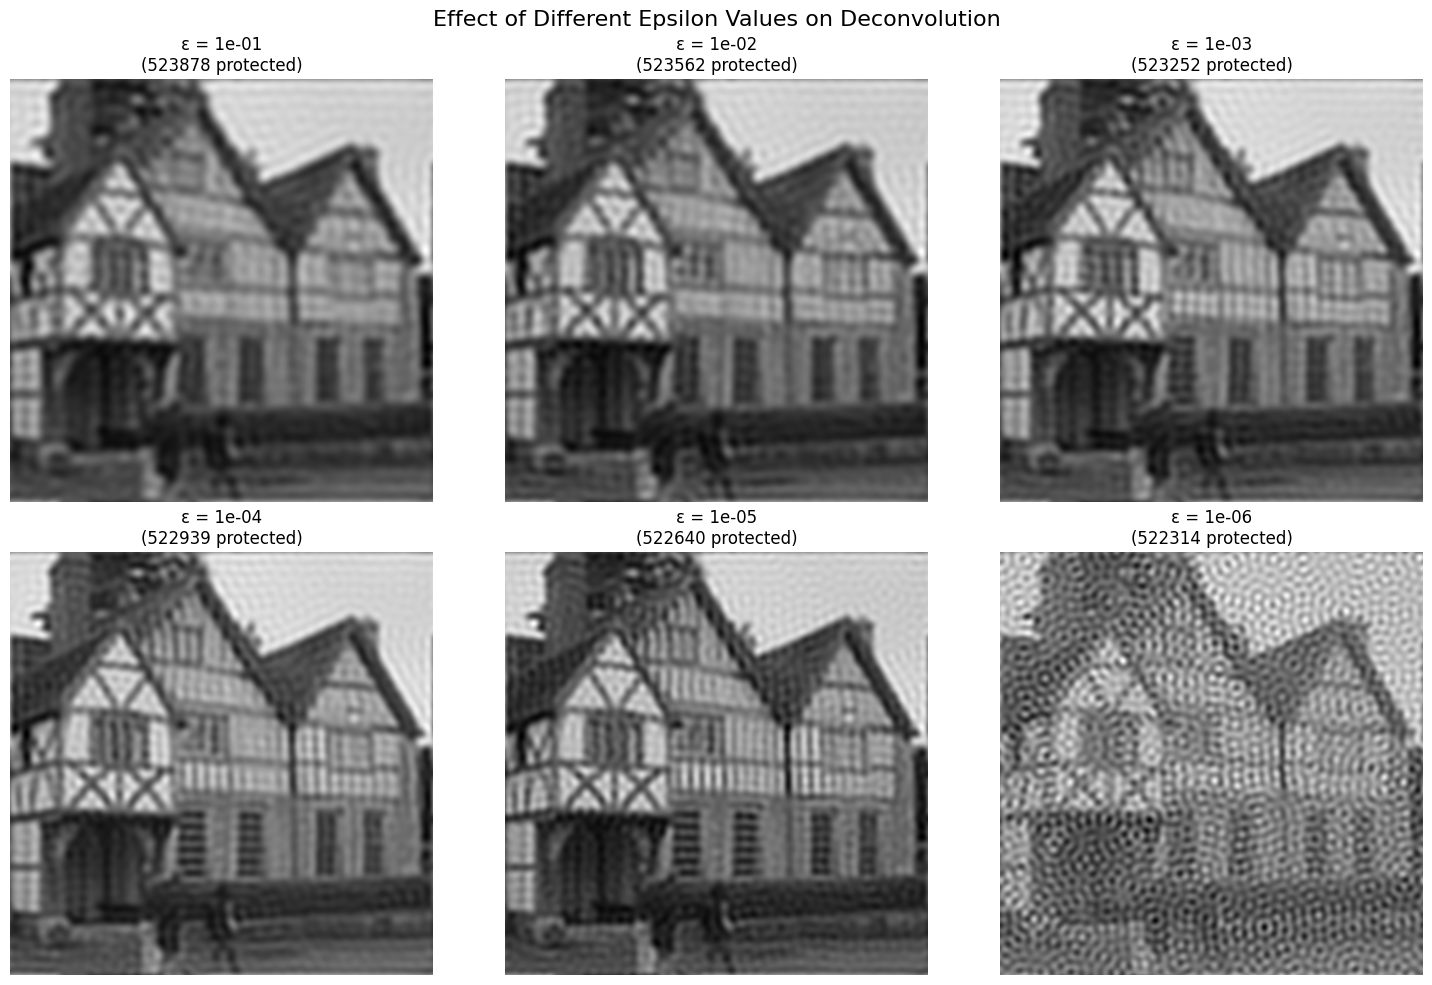


CONCLUSION:
The epsilon parameter represents a fundamental trade-off between:
• Noise amplification (smaller ε = more noise)
• Detail recovery (larger ε = less detail)
• ε ≈ 10⁻³ to 10⁻⁴ typically optimal for most applications
• Perfect deconvolution is theoretically impossible due to information loss


In [13]:
print("\n" + "="*60)
print("PART (D): THEORETICAL LIMITATIONS OF DECONVOLUTION")
print("="*60)

# Analyze the PSF Fourier transform to understand limitations
psf_fft_abs = np.abs(psf_fft)

print(f"\nPSF Fourier Transform Analysis:")
print(f"Maximum value: {psf_fft_abs.max():.6f}")
print(f"Minimum value: {psf_fft_abs.min():.6e}")
print(f"Dynamic range: {psf_fft_abs.max()/psf_fft_abs.min():.2e}")

# Analyze different epsilon values
epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

print(f"\nEpsilon Analysis (σ = {sigma}):")
print("Epsilon\t\tProtected\tRecovered\tTheoretical Limit")
print("-" * 55)

for eps in epsilons:
    mask = np.abs(psf_fft) > eps
    protected = np.sum(~mask)
    recovered = np.sum(mask)
    total = psf_fft.size
    
    print(f"{eps:.0e}\t\t{protected:>6d}\t\t{recovered:>6d}\t\t{protected/total*100:.1f}% lost")

# Theoretical analysis
print(f"\nTHEORETICAL LIMITATIONS:")
print("-" * 40)

print(f"1. INFORMATION LOSS:")
print(f"   - Gaussian PSF with σ={sigma} attenuates high frequencies exponentially")
print(f"   - Frequencies beyond ~1/(2πσ) ≈ {1/(2*np.pi*sigma):.4f} cycles/pixel are severely degraded")
print(f"   - At ε=10⁻³, we lose {np.sum(psf_fft_abs < 1e-3)/psf_fft.size*100:.1f}% of frequency components")

print(f"\n2. NOISE AMPLIFICATION:")
noise_amplification = 1.0 / 1e-3  # worst case when we divide by epsilon
print(f"   - Division by small PSF values amplifies noise")
print(f"   - At ε=10⁻³: noise amplified by up to {noise_amplification:.0f}×")
print(f"   - Signal-to-noise ratio determines practical epsilon limit")

print(f"\n3. OPTIMAL EPSILON SELECTION:")
# Estimate noise level (using high-frequency components as proxy)
high_freq_region = psf_fft_abs[psf_fft_abs.shape[0]//4:, psf_fft_abs.shape[1]//4:]
estimated_noise = np.std(high_freq_region) * 0.1  # rough estimate
optimal_eps = max(estimated_noise, psf_fft_abs.max() * 1e-6)

print(f"   - Too small ε: excessive noise amplification")
print(f"   - Too large ε: loss of recoverable details") 
print(f"   - Estimated noise level: {estimated_noise:.2e}")
print(f"   - Suggested optimal ε: {optimal_eps:.2e}")
print(f"   - Exercise ε=10⁻³ is reasonable compromise")

print(f"\n4. FUNDAMENTAL LIMITS:")
print(f"   - Perfect deconvolution impossible due to:")
print(f"     • Information loss at high frequencies")
print(f"     • Noise amplification at low PSF values")
print(f"     • Finite precision arithmetic")
print(f"     • Model mismatch (real PSF ≠ perfect Gaussian)")

# Demonstrate effect of different epsilon values
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

test_epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

for i, eps in enumerate(test_epsilons):
    # Deconvolve with this epsilon
    deconv_fft = blurred_fft.copy()
    mask = np.abs(psf_fft) > eps
    deconv_fft[mask] = blurred_fft[mask] / psf_fft[mask]
    result = irfft2(deconv_fft)
    
    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(f'ε = {eps:.0e}\n({np.sum(~mask)} protected)')
    axes[i].axis('off')

plt.suptitle('Effect of Different Epsilon Values on Deconvolution', fontsize=16)
plt.tight_layout()
plt.show()

print(f"\nCONCLUSION:")
print(f"The epsilon parameter represents a fundamental trade-off between:")
print(f"• Noise amplification (smaller ε = more noise)")  
print(f"• Detail recovery (larger ε = less detail)")
print(f"• ε ≈ 10⁻³ to 10⁻⁴ typically optimal for most applications")
print(f"• Perfect deconvolution is theoretically impossible due to information loss")